In [1]:
!pip install numpy
!pip install matplotlib
!pip install jupyter_ui_poll

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output, HTML
import random
import time
from itertools import combinations
import requests
from bs4 import BeautifulSoup
import json
import ipywidgets as widgets
from jupyter_ui_poll import ui_events
import os


%matplotlib inline


In [2]:
# Set the function to send data to the google form
def send_to_google_form(data_dict, form_url):
    form_id = form_url[34:90]
    view_form_url = f'https://docs.google.com/forms/d/e/{form_id}/viewform'
    post_form_url = f'https://docs.google.com/forms/d/e/{form_id}/formResponse'

    page = requests.get(view_form_url)
    content = BeautifulSoup(page.content, "html.parser").find('script', type='text/javascript')

    if content is None:
        print("Script tag not found. Data not uploaded.")
        return False

    content_text = content.text[27:-1] if content.text else None

    if not content_text:
        print("Content text not found. Data not uploaded.")
        return False

    try:
        result = json.loads(content_text)[1][1]
        print("Content of the script tag:")
        print(result)
        form_dict = {}
    
        loaded_all = True
        for item in result:
            # It is used to remove non-alphanumeric characters from the item name
            item_name_cleaned = ''.join(char.lower() for char in item[1] if char.isalnum())
            
            # Check if the cleaned item name matches any key in the data dictionary
            matching_keys = [key for key in data_dict.keys() if item_name_cleaned in ''.join(char.lower() for char in key if char.isalnum())]
            
            if not matching_keys:
                print(f"Form item {item[1]} not found. Data not uploaded.")
                loaded_all = False
                return False
            
            # Use the first matching key as the data dictionary key
            form_dict[f'entry.{item[4][0][0]}'] = data_dict[matching_keys[0]]
        
        post_result = requests.post(post_form_url, data=form_dict)
        return post_result.ok
    
    except (json.JSONDecodeError, IndexError) as e:
        print(f"Error decoding JSON or accessing result: {e}")
        return False

In [3]:
# To set the function for cubes drawing
def draw_cubes(cubes, ticks=False, grid=False, view='', flip='', rot=0, ax3d=None):
    # make figure and 3d axes for plotting
    if ax3d is None:
        # Create a figure and 3D axes for plotting
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
    else:
        ax = ax3d
    # The cubes can be plotted using a 3D voxels plot
    ax.voxels(cubes != '', facecolors=cubes, edgecolors='k', shade=False)
    
    nx, ny, nz = cubes.shape

    ax.axes.set_xlim3d(0, nx) 
    ax.axes.set_ylim3d(0, ny) 
    ax.axes.set_zlim3d(0, nz) 
    
    # view argument allows users to set a 2D projection
    if view == 'xy': ax.view_init(90, -90, 0+rot)
    elif view == '-xy': ax.view_init(-90, 90, 0-rot)
    elif view == 'xz': ax.view_init(0, -90, 0+rot)
    elif view == '-xz': ax.view_init(0, 90, 0-rot)
    elif view == 'yz': ax.view_init(0, 0, 0+rot)
    elif view == '-yz': ax.view_init(0, 180, 0-rot)
    else:   ax.view_init(azim=ax.azim+rot)

    # flip argument allows user to show a mirror image
    # flip='x' reverses image in x direction etc.
    if 'x' in flip: ax.axes.set_xlim3d(nx, 0) 
    if 'y' in flip: ax.axes.set_ylim3d(ny, 0) 
    if 'z' in flip: ax.axes.set_zlim3d(nz, 0) 

    # style figure ticks and grid lines
    if ticks==False: 
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis.set_ticklabels([])
            axis.line.set_linestyle('')
            axis._axinfo['tick']['inward_factor'] = 0.0
            axis._axinfo['tick']['outward_factor'] = 0.0
            
    if grid==False and ticks==False: ax.set_axis_off()
    
    if ax3d is not None:
        # return axes with result
        return
    else:
        # show image
        display(fig)
        # delete figure
        plt.close(fig)
    return

In [4]:
# Set buttons
event_info = {
    'type': '',
    'description': '',
    'time': -1
}

def wait_for_event(timeout=-1, interval=0.001, max_rate=20, allow_interupt=True):    
    start_wait = time.time()

    # set event info to be empty
    # as this is dict we can change entries
    # directly without using
    # the global keyword
    event_info['type'] = ""
    event_info['description'] = ""
    event_info['time'] = -1

    n_proc = int(max_rate*interval)+1
    
    with ui_events() as ui_poll:
        keep_looping = True
        while keep_looping==True:
            # process UI events
            ui_poll(n_proc)

            # end loop if we have waited more than the timeout period
            if (timeout != -1) and (time.time() > start_wait + timeout):
                keep_looping = False
                
            # end loop if event has occured
            if allow_interupt==True and event_info['description']!="":
                keep_looping = False
                
            # add pause before looping
            # to check events again
            time.sleep(interval)
    
    # return event description after wait ends
    # will be set to empty string '' if no event occured
    return event_info

# this function lets buttons 
# register events when clicked
def register_event(btn):
    # display button description in output area
    event_info['type'] = "click"
    event_info['description'] = btn.description
    event_info['time'] = time.time()
    return

In [5]:
# This is to creat cubes for the quiz
# Creat a cube for the question first, and for the correct answer, make another cube that with same color but different size of block.
# Since there is a progressive difficulty gradient, the only one argument of this function is the number_of_colors (e.g. 3, 4, or 5). 

def quiz_cubes (cubes3, new_cube, possible_colors, number_of_colors): 
    
    cube_size =5
    projections = ['xy', '-xy', 'xz', '-xz', 'yz', '-yz']
    colors = random.sample(possible_colors, number_of_colors)
    
    # To make similar shapes between cubes3 and new_cube
    random_seed = random.randint(1, 1000)
    np.random.seed(random_seed)
    random.seed(random_seed)
    #Set cubes3
    for color in colors:
        x, y, z = np.random.randint(5, size=3)
        size_x, size_y, size_z = np.random.randint(1, 4, size=3)  # Random block sizes
        cubes3[x:x+size_x, y:y+size_y, z:z+size_z] = color     
    
    # For the new_cube
    np.random.seed(random_seed)
    random.seed(random_seed)
    # Copy the colors from cubes3 to new_cube
    for color in np.unique(cubes3):
        if color in possible_colors:
            new_cube[cubes3 == color] = color   
    # Randomly insert new block sizes into the new cube
    for color in np.unique(new_cube):
        if color in possible_colors:
            x, y, z = np.random.randint(5, size=3)
            size_x, size_y, size_z = np.random.randint(1, 4, size=3)  
            new_cube[x:x+size_x, y:y+size_y, z:z+size_z] = color            
    return  


Question 8:


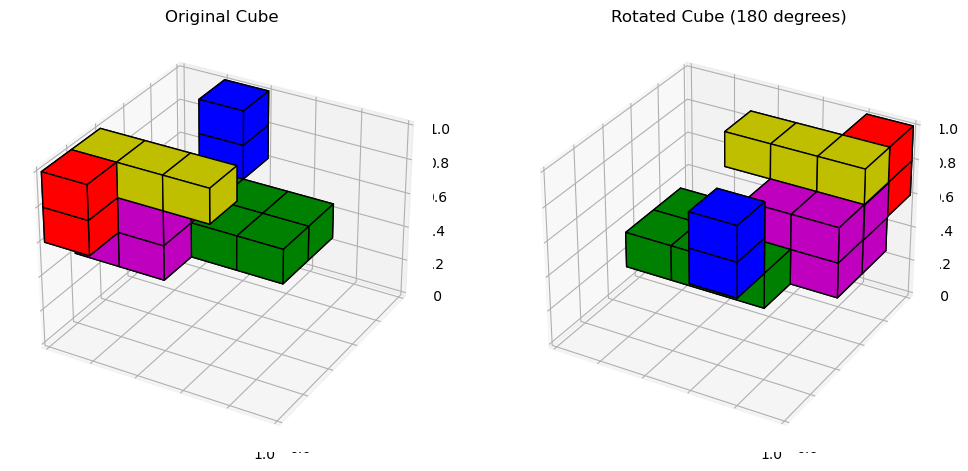

There are four choices: 
Answer A is: 


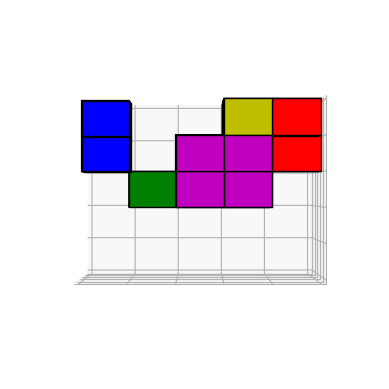

Answer B is:


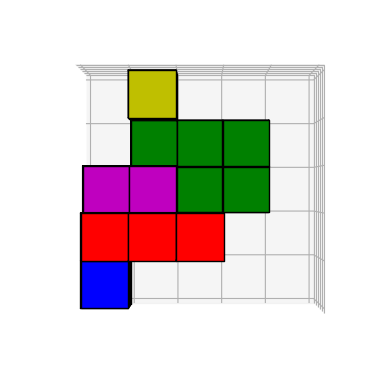

Answer C is: 


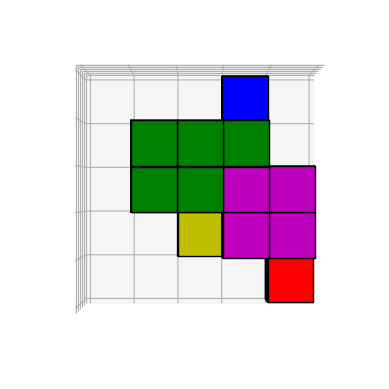

Answer D is: 


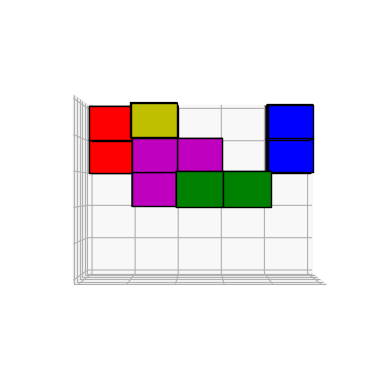

Choose the 2D projection that cannot be made by rotating the arrangement in space:


In [ ]:
# Quiz
# Set up the quiz
choices = ['A', 'B', 'C', 'D']
quiz_questions = []
mark = 0
quiz_duration = 200  # About 3 minutes
quiz_number = 0
incorrect_question = []
quiz_start_time = 0
elapsed_time_1 = []
# To make sure questions are same for the test each time
global_seed = 11
np.random.seed(global_seed)
random.seed(global_seed)

# Set up cubes
for i in range(1000): 
    # Define possible colors and the size for the original cube
    # Define a 3D 5x5x5 string array with entries set to ''
    cubes3 = np.full((5, 5, 5), '')
    new_cube = np.full((5, 5, 5), '') 

    # Define colors
    possible_colors = ['r', 'g', 'b', 'm', 'y']
    
    # Creating a Progressive Difficulty Gradient
    if 0 <= i < 2:
        quiz_cubes (cubes3, new_cube, possible_colors,3)  
    elif 2 <= i <= 4:
        quiz_cubes (cubes3, new_cube, possible_colors,4) 
    else:
       quiz_cubes (cubes3, new_cube, possible_colors,5) 

    # Choose a random correct answer
    correct_answer = random.choice(choices)
    
    # The list of incorrect options by removing the correct answer
    incorrect_choices = [choice for choice in choices if choice != correct_answer]


     # Dictionary to store projections for correct and incorrect answers
    projections = {
        correct_answer: '',
        incorrect_choices[0]: '',
        incorrect_choices[1]: '',
        incorrect_choices[2]: ''
    }
    
    # Add the question to the quiz
    quiz_questions.append({
        'cubes': cubes3,
        'projections': projections,
        'correct_answer': correct_answer,
        'incorrect_answer': incorrect_choices,
        'new_cube': new_cube
    })

# Record the result
results = []
form_url = "https://docs.google.com/forms/d/e/1FAIpQLSc8ClP5JTc9tybJa2g07rE67j55hvpL0TsWz6zJzwB71XNprQ/viewform?usp=sf_link"   

# The data disclaimer question
data_consent_info = """DATA CONSENT INFORMATION:

Please read:

we wish to record your response data
to an anonymised public data repository. 
Your data will be used for educational teaching purposes
practising data analysis and visualisation.

Please type   yes   in the box below if you consent to the upload."""

print(data_consent_info)
result = input("> ").lower()

if result == "yes": 
    print("Thanks for your participation.")
    print("Please contact philip.lewis@ucl.ac.uk")
    print("If you have any questions or concerns")
    print("regarding the stored results.")
else: 
    # end code execution by raising an exception
    raise(Exception("User did not consent to continue test."))



print("This test will last 3 minutes,and you have 30 seconds to answer the please try your best to do more questions!")
id_instructions = """

Enter your anonymised ID

To generate an anonymous 4-letter unique user identifier please enter:
- two letters based on the initials (first and last name) of a childhood friend
- two letters based on the initials (first and last name) of a favourite actor / actress

e.g. if your friend was called Charlie Brown and film star was Tom Cruise
     then your unique identifer would be CBTC
"""

print(id_instructions)
user_id = input("> ").upper()

print("User entered id:", user_id)

print("Please enter your gender: ")
ans2 = input("> ")
print("Please enter your age: ")
ans3 = input("> ")

# Quiz started
quiz_start_time = time.time()


for i, question in enumerate(quiz_questions, 1):
    print(f"Question {i}:")
    question_number = str(i)
    
    # Create a figure with two space 
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
    
    # Plot the first cube
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Original Cube")
    draw_cubes(question['cubes'], grid=True, ax3d=ax1)
 
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Rotated Cube (180 degrees)")
    draw_cubes(question['cubes'], rot=180, grid=True, ax3d=ax2)
    
    # Show the plots
    plt.show()
    print("There are four choices: ")
    
    possible_projections = ['xy', '-xy', 'xz', '-xz', 'yz', '-yz']
    
    # Choose a random correct answer
    correct_answer = random.choice(choices)
    
    # The list of incorrect options by removing the correct answer
    incorrect_choices = [choice for choice in choices if choice != correct_answer]

    # Generate incorrect projections
    for i in range(3):
        incorrect_projection = random.choice(possible_projections)
        possible_projections.remove(incorrect_projection)
        projections[incorrect_choices[i]] = incorrect_projection
    
    # Record the time
    start_time = time.time()
    # Creat content in options
    for choice in choices:
        if choice in incorrect_choices:
            print(f"Answer {choice} is: ")
            draw_cubes(question['cubes'], view=projections[choice], grid=True)
        else: # For correct answer
            correct_projection = random.choice(possible_projections)
            projections[correct_answer] = correct_projection
            print(f"Answer {choice} is:")
            draw_cubes(question['new_cube'], view=projections[correct_answer],grid=True)
             
    print("Choose the 2D projection that cannot be made by rotating the arrangement in space:")        
    
    # Create buttons
    btn1 = widgets.Button(description="A")
    btn2 = widgets.Button(description="B")
    btn3 = widgets.Button(description="C")
    btn4 = widgets.Button(description="D")
    
    # Display the buttons
    panel = widgets.HBox([btn1, btn2, btn3,btn4])
    display(panel)
    
    # Set up event handlers
    btn1.on_click(register_event)
    btn2.on_click(register_event)
    btn3.on_click(register_event)
    btn4.on_click(register_event)

    clear_output(wait=True)
    
    result = wait_for_event(timeout=30)
    clear_output()
    
    current_result = {
        'Cubes': [],
        'New_cube': [],
        'Time spent': [],
        'Correct': []
    } # used to store the lists of data
    
    # Calculate the elaped time
    elapsed_time = time.time() - start_time

    # Result
    if result['description'] == correct_answer:
        print("Correct! Well done.")
        mark +=1
        print(f"You spent {elapsed_time:.2f} seconds on this problem")
        print(f"Your time left:{quiz_duration - time.time() + quiz_start_time:.2f} seconds ")
        current_result['Correct'].append('1')
    else:
        print(f"Sorry, that's incorrect. The correct answer is {correct_answer}.")
        draw_cubes(question['new_cube'], view=projections[correct_answer])
        print(f"You spent {elapsed_time:.2f} seconds on this problem")
        print(f"Your time left:{quiz_duration + quiz_start_time - time.time():.2f} seconds ")
        incorrect_question.append(question_number) # used to collect the incorrect question (although there is data for being correct or not)
        current_result['Correct'].append('0')

    # Adding data
    elapsed_time_1.append(elapsed_time)


    # Interval between questions
    interval = wait_for_event(timeout=2)
    clear_output()
    quiz_number +=1

    # Stop the quiz
    if time.time() - quiz_start_time > quiz_duration:
        clear_output(wait=True)
        print(f"Time is up")
        break
        
print(f"Congratulations! You've completed the quiz, and your mark is {mark}")



data_dict = {
    'User ID': user_id,
    'Gender': ans2,
    'Age': ans3,
    'Number of questions answered': quiz_number,
    'Scores': mark,
    'Incorrect question': incorrect_question,
    'elapsed_time_1': elapsed_time_1,
    }

# send data to google form
upload_success = send_to_google_form(data_dict, form_url)

# Print the result
if upload_success:
    print("Data uploaded successfully!")
else:
    print("Data upload failed.")
    